# RDAI NLP Project

The aim of this project is to use the CNN learnt during the course as well as more state-of-the-art models and compare the performance after training/fine-tuning.

In [1]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import pandas as pd
import numpy as np

import tensorflow as tf
import keras

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# can use Text Vectorization Layer if you want to


from tensorflow.keras.optimizers import Adam

2024-10-09 11:18:37.562865: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 11:18:37.563674: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 11:18:37.565882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 11:18:37.572485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 11:18:37.583730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Data Exploration

In [2]:
path_to_data = 'data/bbc_data.csv'

data_df = pd.read_csv(path_to_data).fillna("blank")

In [3]:
data_df.head(5)

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [4]:
print(f"Total number of data entries: {data_df.shape[0]}\n")
distribution = data_df['labels'].value_counts()

print("The distribution of data:")
print(distribution)

Total number of data entries: 2225

The distribution of data:
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


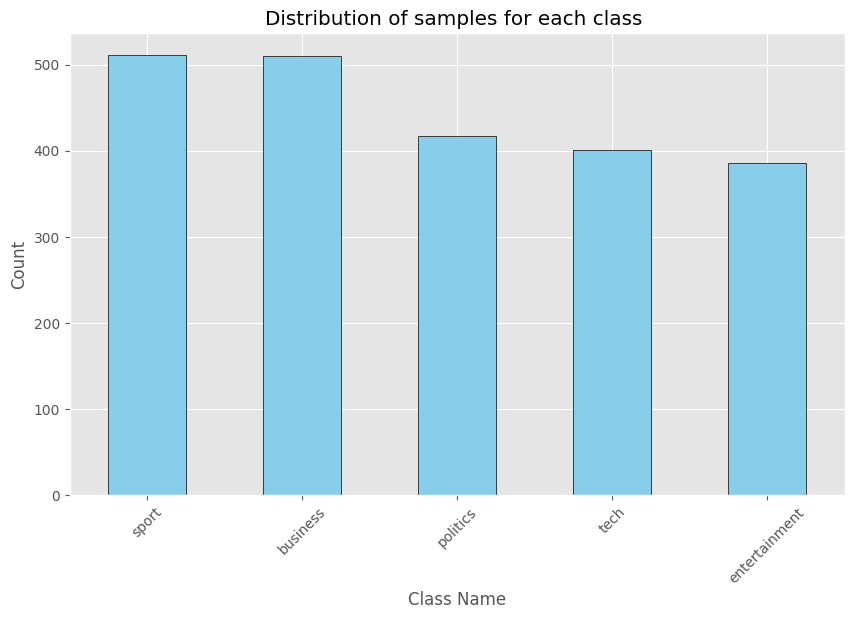

In [5]:
# Plot the distribution of data
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of samples for each class ')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Balancing the labels for a more even learning

In [6]:
min_count = data_df['labels'].value_counts().min()

balanced_df = data_df.groupby('labels').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

distribution = balanced_df['labels'].value_counts()
distribution

/tmp/ipykernel_50588/3951338146.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = data_df.groupby('labels').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


labels
business         386
entertainment    386
politics         386
sport            386
tech             386
Name: count, dtype: int64

In [7]:
sample_no = 5

print(f"BBC description samples:\n {balanced_df.sample(n=sample_no)}")

BBC description samples:
                                                    data    labels
1866  Mobiles rack up 20 years of use  Mobile phones...      tech
1493  Greek pair attend drugs hearing  Greek sprinte...     sport
905   Tories unveil quango blitz plans  Plans to abo...  politics
808   Defection timed to hit tax pledge  With impecc...  politics
344   Ukraine steel sell-off illegal  The controvers...  business


### One- Hot Encoding

In [8]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

balanced_df = balanced_df.sample(frac=1)

# List of class labels
labels = ['business', 'entertainment', 'politics', 'sport', 'tech']

y = balanced_df['labels']

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

y_data = tf.keras.utils.to_categorical(y_int, num_classes=len(labels))
X_data = balanced_df['data'].values

In [66]:
y_int

array([0, 2, 3, ..., 4, 2, 3])

In [9]:
y_data[4]

array([0., 0., 0., 0., 1.])

In [10]:
X_data

array(['S&N extends Indian beer venture  The UKs biggest brewer, Scottish and Newcastle (S&N), is to buy 37.5% of Indias United Breweries in a deal worth 4.66bn rupees ($106m:xc2xa354.6m).  S&N will buy a 17.5% equity stake in United, maker of the well-known Kingfisher lager brand, and make a public offer to buy another 20% stake. A similar holding will be controlled by Vijay Mallya, chair of the Indian firm. The deal was a "natural development" of its joint venture with United, said Tony Froggatt, S&Ns chief executive.  Its top brands include Newcastle Brown Ale, Fosters, John Smiths, Strongbow and Kronenbourg. In 2002 S&N and United agreed to form a strategic partnership, one that would include a joint venture business and a UK investment in the Indian brewer. The joint venture was established in May 2003. with both parties having a 40% stake in the venture - Millennium Alcobev. Millennium Alcobev will now be merged with United, which expects post-merger to have about half of Indias 

### Split train-test dataframes

In [11]:
# Split into train and validation sets
train_set_percentage = .9

dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))

train_dataset = dataset.take(int(len(dataset)*train_set_percentage)) 
test_dataset =  dataset.skip(int(len(dataset)*train_set_percentage))

I0000 00:00:1728443919.017419   50588 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-09 11:18:39.033352: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
len(test_dataset)

193

In [13]:
def calculate_class_weights(y_train):
    num_samples, num_classes = y_train.shape
    print(f"num_samples: {num_samples}, num_classes: {num_classes}")
    class_weights = {}

    for class_index in range(num_classes):
        # Count the number of positive samples for this class
        num_positive_samples = np.sum(y_train[:, class_index])

        # Calculate the weight for this class
        weight = (num_samples / num_classes) / num_positive_samples

        class_weights[class_index] = weight

    return class_weights

# Get the class weights
class_weights = calculate_class_weights(y_data)

num_samples: 1930, num_classes: 5


In [14]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

## CNN Model

### Setting up vectorise model

In [15]:
# Define the maximum number of words in your vocabulary
max_words = 1000
# Define the sequence length
max_len = 500

from keras.layers import TextVectorization

# Create a TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=max_len
)

# Adapt the layer to your training data (this builds the vocabulary)
text_ds = train_dataset.map(lambda x, y: x)

vectorize_layer.adapt(text_ds)

2024-10-09 11:18:42.391099: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'for',
 'is',
 'that',
 'on',
 'said',
 'it',
 'was',
 'be',
 'he',
 'with',
 'as',
 'has',
 'have',
 'at',
 'will',
 'by',
 'are',
 'but',
 'not',
 'from',
 'i',
 'its',
 'mr',
 'they',
 'his',
 'this',
 'an',
 'we',
 'which',
 'had',
 'would',
 'been',
 'their',
 'more',
 'were',
 'also',
 'who',
 'people',
 'up',
 'new',
 'us',
 'about',
 'one',
 'there',
 'or',
 'than',
 'out',
 'can',
 'after',
 'all',
 'if',
 'could',
 'year',
 'you',
 'over',
 'last',
 'when',
 'years',
 'first',
 'other',
 'time',
 'what',
 'into',
 'two',
 'some',
 'now',
 'so',
 'she',
 'government',
 'them',
 'do',
 'uk',
 'just',
 'best',
 'world',
 'being',
 'no',
 'only',
 'make',
 'get',
 'music',
 'against',
 'such',
 'film',
 'very',
 'told',
 'like',
 'many',
 'because',
 'made',
 'her',
 'game',
 'should',
 'before',
 'number',
 'while',
 'next',
 'well',
 'most',
 'three',
 'bbc',
 'back',
 'take',
 'any',
 'added',
 'way',
 'our',
 'says',


### Batching

In [17]:
# batch & prefetch the dataset
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

### Setting up model for training

In [18]:
from keras.models import Model
from keras.layers import LSTM, Input, Dense, Embedding, Dropout
from keras.optimizers import Adam
from keras.layers import Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [19]:
Inp = Input(shape=(1,),dtype=tf.string, name='text_input')
x = vectorize_layer(Inp)
x = Embedding(max_words, 48, input_length=max_len, name='embedding')(x)
x = Conv1D(128, 5, activation='relu', name = 'Conv_01')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(filters=32, kernel_size=8, activation='relu', name='Conv_02')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5, name='Dropout_01')(x)
#x = LSTM(64, name='LSTM')(x)
x = Dense(256, activation='relu', name='Dense_01')(x)
x = Dropout(0.5, name='Dropout_02')(x)
out = Dense(5, activation='sigmoid', name='outputs')(x)

/home/digitalhub/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
model = Model(inputs=Inp,outputs=out)

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 500)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 48)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_01 (Conv1D)                │ (None, 496, 128)       │        30,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_02 (Conv1D)                │ (None, 92, 32)         │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_01 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_01 (Dense)                │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_02 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,381 (474.14 KB)

 Trainable params: 121,381 (474.14 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

epochs = 50

history = model.fit(train_dataset,
          epochs=epochs,
          validation_data=test_dataset,
          callbacks=[early_stopping],
          class_weight=class_weights
          )

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2352 - loss: 0.5139 - val_accuracy: 0.2021 - val_loss: 0.5022
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2285 - loss: 0.5075 - val_accuracy: 0.2798 - val_loss: 0.4993
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2388 - loss: 0.5051 - val_accuracy: 0.2487 - val_loss: 0.4932
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2917 - loss: 0.4906 - val_accuracy: 0.3523 - val_loss: 0.4573
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3484 - loss: 0.4484 - val_accuracy: 0.3575 - val_loss: 0.4104
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4229 - loss: 0.3980 - val_accuracy: 0.4301 - val_loss: 0.3916
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4526 - loss: 0.3781 - val_accuracy: 0.5026 - val_loss: 0.3719
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5095 - loss: 0.3544 - val_accuracy: 0.5440 - v

In [23]:
metrics = model.evaluate(test_dataset)

print("model accuracy:",metrics[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.0450 
model accuracy: 0.9689119458198547


## Extra Testing

In [72]:
# Taken from 09102023 BBC news paper about 7-eleven (Business related)

text = [f"Shares in the owner of convenience store giant 7-Eleven have jumped after a report that it has received a new takeover offer from Canadian rival Alimentation Couche-Tard. The new offer values Japan's Seven & i Holdings at more than $47bn (£36bn), which is around 20% higher than Couche-Tard's original offer, according to Bloomberg News. In September, Seven & i rejected a $38bn approach from Couche-Tard, saying it grossly undervalued the firm and that any potential takeover would face major regulatory hurdles. BBC News has contacted Couche-Tard and Seven & i for comment."]
labels = ['business','entertainment','politics','sport','tech']

def predict(text, model, threshold = 0.4):
    predictions = model.predict(tf.constant(text))
    print(predictions)
    binary_predictions = (predictions > threshold).astype(int)

    for i in range(len(binary_predictions[0])):
        if binary_predictions[0][i] == 1:
            print(f"Label: {labels[i]} (Predicted probability: {predictions[0][i]:.4f})")

In [73]:
threshold = 0.4

predict(text=text, model=model, threshold=threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[0.802858   0.03388678 0.03825943 0.20443755 0.01462892]]
Label: business (Predicted probability: 0.8029)


In [75]:
# Taken from 09102023 BBC news paper about People who run aroudn in circles for 24hrs (Sports related)

text = [f"It is midnight in central London and the rain is bouncing off the ground. Most of the city is asleep, but on an athletics track just south of the River Thames one man - shivering and soaked to the bone in shorts, T-shirt and makeshift gilet fashioned from a black bin bag - is running laps. A pensioner, who flew in from Norway that morning, is doing the same in a blue pound-shop poncho. There is a small pile of vomit on the inside of the track, where a runner emptied his stomach an hour earlier. Job done, he picked himself up and carried on."]
labels = ['business','entertainment','politics','sport','tech']

In [76]:
predict(text=text, model=model, threshold=threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[0.12958102 0.10147154 0.02911542 0.83221674 0.03534013]]
Label: sport (Predicted probability: 0.8322)


## Analysis

Overall the model seems to perform well enough even when the model isnt very sophisticated or big. 
It can reliably predict the class from more recent BBC articles.

## Trying out SOT model

After looking around, it seems that roBERTa would be great for this use case and as such would use huggingface to finetune the model

Reference: https://achimoraites.medium.com/fine-tuning-roberta-for-topic-classification-with-hugging-face-transformers-and-datasets-library-c6f8432d0820

In [78]:
import torch
from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)
from huggingface_hub import HfFolder, notebook_login

In [ ]:
notebook_login()